# Installing Libraries

In [61]:
!pip install mediapipe

     |████████████████████████████████| 30.4 MB 80 kB/s 


# Import Libraries

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [79]:
import numpy as np 
import pandas as pd
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten , Conv2D,Dropout
from tensorflow.keras.models import Model,Sequential, load_model
from tensorflow.keras.preprocessing import image , image_dataset_from_directory 
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.activations import relu,softmax,tanh
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import tensorflow as tf
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from IPython.display import display,clear_output
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,MaxPool2D
from keras import optimizers,regularizers,metrics
from sklearn.metrics import confusion_matrix
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.image as mpimg
import dlib
import yaml
import mediapipe as mp

# Visualize Samples of Data

In [12]:
real = '/content/drive/MyDrive/DL_Project/real/real_vs_fake/valid/real'
fake = '/content/drive/MyDrive/DL_Project/real/real_vs_fake/valid/fake'

def plot_image(path, title):
    plt.figure(figsize=(10,10))
    for i in range(9):
        img = load_img(path +'/' +os.listdir(path)[i])
        plt.subplot(3,3,i+1)
        plt.imshow(img)
        if title=='Fake Faces':
            plt.title(os.listdir(path)[i][:4])
        plt.suptitle(title, fontname="Times New Roman",fontweight="bold");
        plt.axis('off')
    return plt

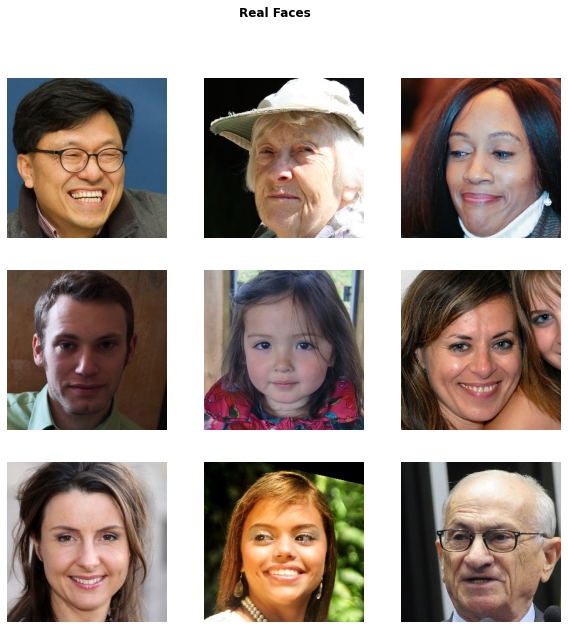

In [13]:
plot_image(real, 'Real Faces').show();

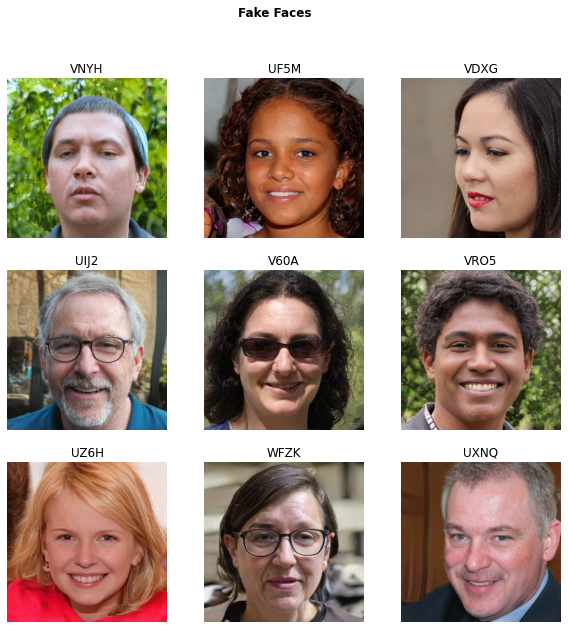

In [14]:
plot_image(fake, 'Fake Faces').show();

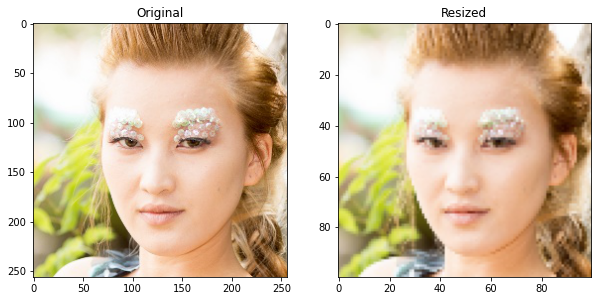

In [ ]:
img  = plt.imread('/content/drive/MyDrive/DL_Project/real/real_vs_fake/train/real/69998.jpg')

plt.figure(figsize=(10,13))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(img);

plt.subplot(1,2,2)
plt.imshow(cv.resize(img, (100, 100)), cmap='gray')
plt.title('Resized');

# Image Processing

### Background Removal Using Opencv 

In [29]:
background_removal_model = yaml.load('/content/drive/MyDrive/Colab Notebooks/SIC Graduation Project/model.yml')

In [30]:
def filterOutSaltPepperNoise(edgeImg):
    # Get rid of salt & pepper noise.
    count = 0
    lastMedian = edgeImg
    median = cv.medianBlur(edgeImg, 3)
    while not np.array_equal(lastMedian, median):
        # get those pixels that gets zeroed out
        zeroed = np.invert(np.logical_and(median, edgeImg))
        edgeImg[zeroed] = 0

        count = count + 1
        if count > 50:
            break
        lastMedian = median
        median = cv.medianBlur(edgeImg, 3)
        return median

def findLargestContour(edgeImg):
    contours, hierarchy = cv.findContours(
        edgeImg,
        cv.RETR_EXTERNAL,
        cv.CHAIN_APPROX_SIMPLE
    )

    # From among them, find the contours with large surface area.
    contoursWithArea = []
    for contour in contours:
        area = cv.contourArea(contour)
        contoursWithArea.append([contour, area])
		
    contoursWithArea.sort(key=lambda tupl: tupl[1], reverse=True)
    largestContour = contoursWithArea[0][0]
    return largestContour

In [41]:
def BackgroundRemoval(img):
    images = []
# Gaussian Blur
    g_blurred = cv.GaussianBlur(img, (3, 3), 0)


# Apply Forest Edge Detection
    blurred_float = g_blurred.astype(np.float32) / 255.0
    edgeDetector = cv.ximgproc.createStructuredEdgeDetection(background_removal_model)
    edges = edgeDetector.detectEdges(blurred_float) * 255.0


# Filter Out Salt & Pepper Noise
    edges_8u = np.asarray(edges, np.uint8)
    edges_8u = filterOutSaltPepperNoise(edges_8u)
    images.append(edges_8u)

# Find Largest Contours
    contour = findLargestContour(edges_8u)
    # Draw the contour on the original image
    contourImg = np.copy(img)
    cv.drawContours(contourImg, [contour], 0, (0, 255, 0), 2, cv.LINE_AA, maxLevel=1)
    images.append(contourImg)

# Grapcut Algorithm to Get Exact Edges
    mask = np.zeros_like(edges_8u)
    cv.fillPoly(mask, [contour], 255)

    # calculate sure foreground area by dilating the mask
    mapFg = cv.erode(mask, np.ones((5, 5), np.uint8), iterations=10)

    # mark inital mask as "probably background"
    # and mapFg as sure foreground
    trimap = np.copy(mask)
    trimap[mask == 0] = cv.GC_BGD
    trimap[mask == 255] = cv.GC_PR_BGD
    trimap[mapFg == 255] = cv.GC_FGD

    # visualize trimap
    trimap_print = np.copy(trimap)
    trimap_print[trimap_print == cv.GC_PR_BGD] = 128
    trimap_print[trimap_print == cv.GC_FGD] = 255
    images.append(trimap_print)

# run grabcut
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (0, 0, mask.shape[0] - 1, mask.shape[1] - 1)
    cv.grabCut(img, trimap, rect, bgdModel, fgdModel, 5, cv.GC_INIT_WITH_MASK)

    # create mask again
    mask2 = np.where(
        (trimap == cv.GC_FGD) | (trimap == cv.GC_PR_FGD), 255, 0).astype('uint8')

    images.append(mask2)

# Contour Detection Again To Fill The Holes
    contour2 = findLargestContour(mask2)
    mask3 = np.zeros_like(mask2)
    cv.fillPoly(mask3, [contour2], 255)



    # blended alpha cut-out
    mask3 = np.repeat(mask3[:, :, np.newaxis], 3, axis=2)
    mask4 = cv.GaussianBlur(mask3, (3, 3), 0)
    alpha = mask4.astype(float) * 1.1  # making blend stronger
    alpha[mask3 > 0] = 255.0
    alpha[alpha > 255] = 255.0

    foreground = np.copy(img).astype(float)
    foreground[mask4 == 0] = 0
    background = np.ones_like(foreground, dtype=float) * 255.0

    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = alpha / 255.0
    # Multiply the foreground with the alpha matte
    foreground = cv.multiply(alpha, foreground)
    # Multiply the background with ( 1 - alpha )
    background = cv.multiply(1.0 - alpha, background)
    # Add the masked foreground and background.
    cutout = cv.add(foreground, background)

    cutout = cutout.astype(np.uint8)
    images.append(cutout)

    return images

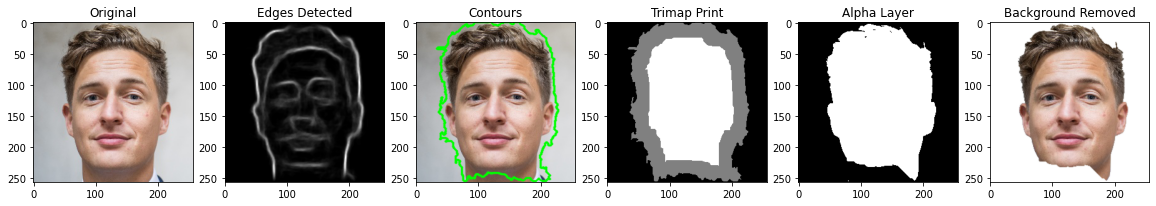

In [50]:
img  = plt.imread('/content/drive/MyDrive/DL_Project/real/real_vs_fake/test/real/01476.jpg')
img_rb = BackgroundRemoval(img)

plt.figure(figsize=(20,13))

plt.subplot(1,6,1)
plt.imshow(img);
plt.title('Original')

plt.subplot(1,6,2)
plt.imshow(img_rb[0], cmap='gray')
plt.title('Edges Detected');

plt.subplot(1,6,3)
plt.imshow(img_rb[1])
plt.title('Contours');

plt.subplot(1,6,4)
plt.imshow(img_rb[2], cmap='gray')
plt.title('Trimap Print');

plt.subplot(1,6,5)
plt.imshow(img_rb[3], cmap='gray')
plt.title('Alpha Layer');

plt.subplot(1,6,6)
plt.imshow(img_rb[4])
plt.title('Background Removed');

### Face Landmarks

In [55]:
# Use detector to find landmarks
detector = dlib.get_frontal_face_detector()

# Load the predictor
predictor = dlib.shape_predictor("/content/drive/MyDrive/Colab Notebooks/SIC Graduation Project/shape_predictor_68_face_landmarks.dat")

In [56]:
def face_landmarks(image):
    
    gray = cv.cvtColor(src=image, code=cv.COLOR_BGR2GRAY)

    faces = detector(gray)
    for face in faces:
        x1 = face.left() # left point
        y1 = face.top() # top point
        x2 = face.right() # right point
        y2 = face.bottom() # bottom point
        # Create landmark object
        landmarks = predictor(image=gray, box=face)
        # Loop through all the points
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            # Draw a circle
            cv.circle(img=image, center=(x, y), radius=3, color=(0, 255, 0), thickness=-1)
    # Return the image
    return image

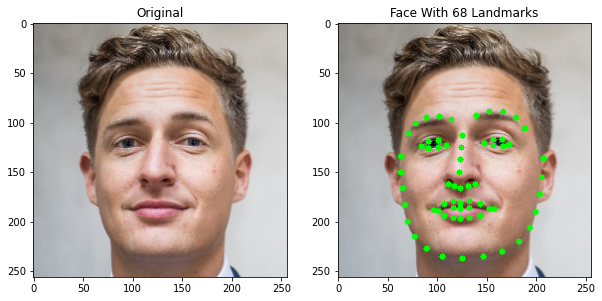

In [59]:
img  = plt.imread('/content/drive/MyDrive/DL_Project/real/real_vs_fake/test/real/01476.jpg')
img_landmarks = img.copy()
img_landmarks = face_landmarks(img_landmarks)

plt.figure(figsize=(10,13))
plt.subplot(1,2,1)
plt.imshow(img);
plt.title('Original')

plt.subplot(1,2,2)
plt.imshow(img_landmarks)
plt.title('Face With 68 Landmarks');

### Face Features

In [67]:
def face_features(image):    
    
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_face_mesh = mp.solutions.face_mesh

    # For static images:
    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        min_detection_confidence=0.5) as face_mesh:

        results = face_mesh.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))


        # Print and draw face mesh landmarks on the image.

        annotated_image = image.copy()

        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=annotated_image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles
                .get_default_face_mesh_tesselation_style())
            mp_drawing.draw_landmarks(
                image=annotated_image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_CONTOURS,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles
                .get_default_face_mesh_contours_style())

        return annotated_image

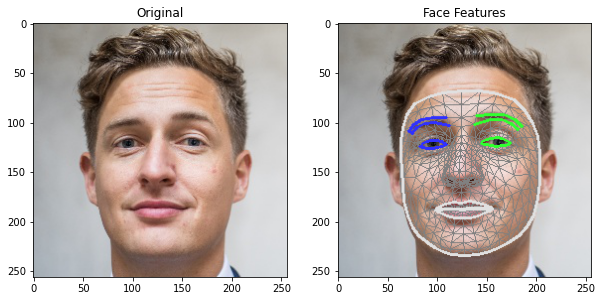

In [69]:
img  = plt.imread('/content/drive/MyDrive/DL_Project/real/real_vs_fake/test/real/01476.jpg')
img_features = face_features(img)

plt.figure(figsize=(10,13))
plt.subplot(1,2,1)
plt.imshow(img);
plt.title('Original')

plt.subplot(1,2,2)
plt.imshow(img_features)
plt.title('Face Features');

# Deep Learning Models

## Image Data Generator

In [71]:
train_path = '/content/drive/MyDrive/DL_Project/real/real_vs_fake/test'

train_datagen =    ImageDataGenerator(rescale=1./255, validation_split=0.7)

train_generator = train_datagen.flow_from_directory(train_path,
                                      class_mode='categorical',
                                      shuffle=True,
                                      color_mode='rgb',
                                      target_size=(100,100),
                                      subset='training')

valid_path = '/content/drive/MyDrive/DL_Project/real/real_vs_fake/valid'

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

validation_generator = valid_datagen.flow_from_directory(valid_path,
                                     class_mode='categorical',
                                     shuffle=True,
                                     color_mode='rgb',
                                     target_size=(100,100),
                                     subset='validation')

Found 6000 images belonging to 2 classes.
Found 2826 images belonging to 2 classes.


## Function for Prediction

In [ ]:
def load_image(filename, model):
    test_image= image.load_img(filename, target_size = (100, 100) ) 
    test_image = np.array(test_image).astype('float32')/225
    test_image = np.expand_dims(test_image, axis=0)

    score = model.predict(test_image, batch_size=32)
    classes = np.argmax(score, axis = 1)
    
    img = mpimg.imread(filename)
    imgplot = plt.imshow(img)
    plt.show()

    if classes == 0:
          gt = "Fake"
    else:
          gt = "Real"


    print(gt)

## CNN Model

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(100,100,3)))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [ ]:
train_steps = 6000 / 64
validation_steps = 2355 / 64
hist =model.fit(
    train_generator,
    validation_data = validation_generator, 
    epochs = 20,
    steps_per_epoch=train_steps, validation_steps=validation_steps )

Epoch 1/5
93/93 [==============================] - 104s 1s/step - loss: 0.8079 - accuracy: 0.5532 - val_loss: 0.6930 - val_accuracy: 0.5093
Epoch 2/5
93/93 [==============================] - 102s 1s/step - loss: 0.6616 - accuracy: 0.6021 - val_loss: 0.6893 - val_accuracy: 0.5743
Epoch 3/5
93/93 [==============================] - 101s 1s/step - loss: 0.6569 - accuracy: 0.6247 - val_loss: 0.6756 - val_accuracy: 0.5997
Epoch 4/5
93/93 [==============================] - 101s 1s/step - loss: 0.6259 - accuracy: 0.6549 - val_loss: 0.6559 - val_accuracy: 0.6495
Epoch 5/5
93/93 [==============================] - 101s 1s/step - loss: 0.5955 - accuracy: 0.6862 - val_loss: 0.6366 - val_accuracy: 0.6478


No handles with labels found to put in legend.
No handles with labels found to put in legend.


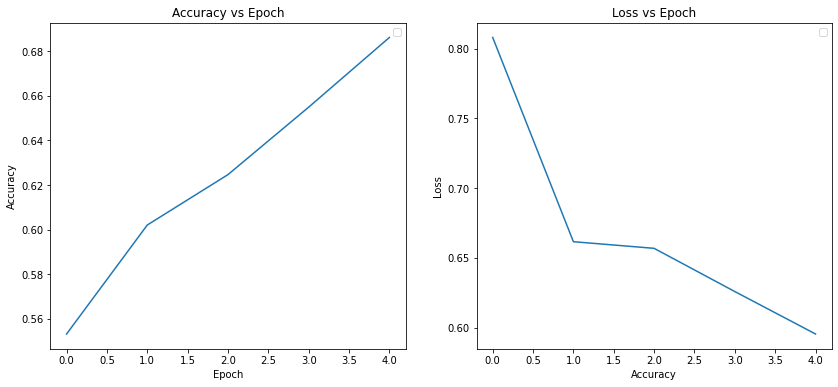

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.title('Loss vs Epoch')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.legend()
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
{'loss': [0.8079153299331665, 0.661598265171051, 0.6568537950515747, 0.6258913278579712, 0.5954960584640503], 'accuracy': [0.5531914830207825, 0.6020611524581909, 0.6246657967567444, 0.654920220375061, 0.6861631274223328], 'val_loss': [0.6930271983146667, 0.6893337965011597, 0.675574541091919, 0.6559282541275024, 0.63662189245224], 'val_accuracy': [0.5092905163764954, 0.5743243098258972, 0.599662184715271, 0.6494932174682617, 0.6478040814399719]}


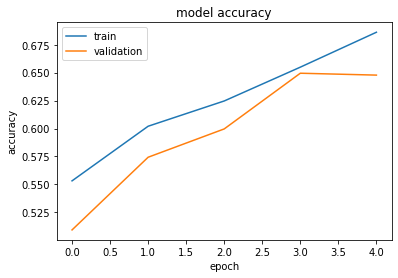

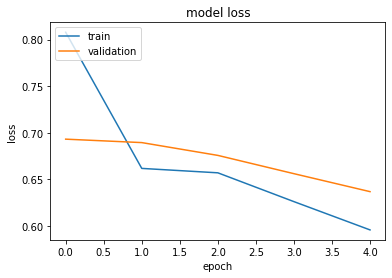

In [ ]:
print(hist.history.keys())
print(hist.history)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

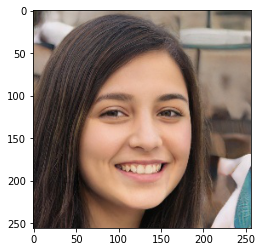

Real


In [ ]:
load_image('/content/drive/MyDrive/DL_Project/real/real_vs_fake/test/fake/ZXWNSBQLTJ.jpg', model)

## DenseNet121 (TL) Model

In [70]:
from tensorflow.keras.applications import DenseNet121

In [72]:
densenet_model = DenseNet121(input_shape=(100, 100, 3),
                        include_top=False,
                        weights='imagenet'
                       )
densenet_model = Sequential([densenet_model,
                                    MaxPool2D(pool_size=(2,2)),
                                    Flatten(),
                                    Dense(512, activation='relu'),
                                    BatchNormalization(),
                                    Dropout(0.2),
                                    Dense(2, activation='sigmoid')
                                   ])
densenet_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

densenet_model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 3, 3, 1024)        7037504   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________

In [73]:
tensorboard = TensorBoard(log_dir = 'logs')


reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [98]:
train_steps = 6000 / 64
validation_steps = 2500 / 64

hist =densenet_model.fit(
    train_generator,
    validation_data = validation_generator, 
    epochs = 20,
    steps_per_epoch=train_steps, validation_steps=validation_steps, callbacks=[tensorboard, reduce_lr])

Epoch 1/2
10/10 [==============================] - 151s 16s/step - loss: 0.6434 - accuracy: 0.7031 - val_loss: 2.3946 - val_accuracy: 0.4719
Epoch 2/2
10/10 [==============================] - 134s 14s/step - loss: 0.6509 - accuracy: 0.6750 - val_loss: 1.4485 - val_accuracy: 0.4812


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
{'loss': [0.5729750990867615, 0.5092759132385254, 0.48202627897262573, 0.43794339895248413, 0.33943378925323486], 'accuracy': [0.6985294222831726, 0.7503342032432556, 0.7663770318031311, 0.7978723645210266, 0.8519384860992432], 'val_loss': [0.6822720766067505, 0.5936746001243591, 0.630210280418396, 0.683209240436554, 0.6772035956382751], 'val_accuracy': [0.6187499761581421, 0.7093750238418579, 0.684374988079071, 0.66796875, 0.706250011920929], 'lr': [0.001, 0.001, 0.001, 0.001, 0.00040000002]}


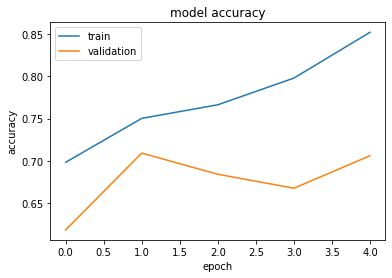

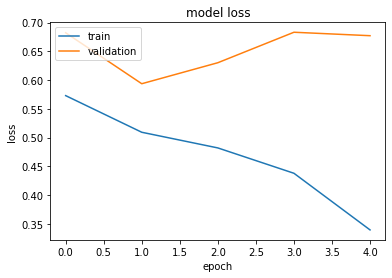

In [ ]:
print(hist.history.keys())
print(hist.history)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

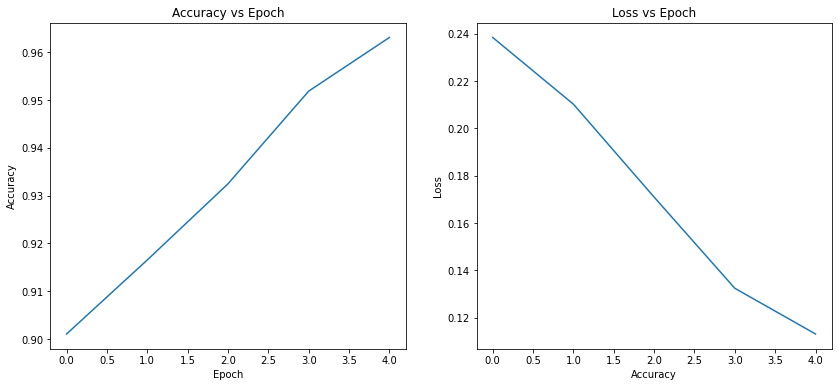

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.title('Loss vs Epoch')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.show()


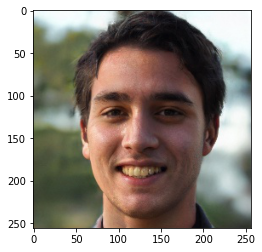

Fake


In [ ]:
load_image('/content/drive/MyDrive/DL_Project/real/real_vs_fake/train/fake/ZZWVFJMIU1.jpg', densenet_model)